In [1]:
# Cell 1: Install Dependencies and Import Libraries
# This cell installs compatible versions of neuralforecast and pytorch-lightning
# Also imports all necessary Python libraries for the project

!pip uninstall -y neuralforecast pytorch-lightning
!pip install neuralforecast pytorch-lightning==2.0.0 yfinance matplotlib scikit-learn

import pandas as pd
import numpy as np
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeMixer
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Verify versions
import pytorch_lightning as pl
import neuralforecast as nf
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"NeuralForecast version: {nf.__version__}")
print("Environment setup complete!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.2/263.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0
PyTorch Lightning version: 2.0.0
NeuralForecast version: 3.1.2
Environment setup complete!


In [2]:
# Cell 2: Mount Google Drive and Set Data Paths
# This mounts your Google Drive to access the existing datasets

from google.colab import drive
drive.mount('/content/drive')

# Set the base path to your Volatility Forecasting folder
BASE_PATH = '/content/drive/MyDrive/Volatility_Forecasting/'

# Define paths for data, models, and results
DATA_PATH = BASE_PATH + 'Data/'
MODEL_PATH = BASE_PATH + 'Models/'
RESULTS_PATH = BASE_PATH + 'Results/'

# Create directories if they don't exist
import os
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print("Google Drive mounted successfully!")
print(f"Data path: {DATA_PATH}")


Mounted at /content/drive
Google Drive mounted successfully!
Data path: /content/drive/MyDrive/Volatility_Forecasting/Data/


In [3]:
# Cell 3: Define Helper Functions for Data Preprocessing
# These functions compute volatility and prepare dataframes for TimeMixer

def compute_volatility(df):
    """
    Compute annualized volatility using rolling 21-day window
    Formula: sqrt(252) * std(log(returns), window=21)
    """
    print("Computing volatility...")

    # Group by ticker to compute log returns
    df['log_return'] = df.groupby('Ticker')['Close'].transform(
        lambda x: np.log(x / x.shift(1))
    )

    # Compute rolling volatility (21-day window), annualized
    df['volatility'] = df.groupby('Ticker')['log_return'].transform(
        lambda x: np.sqrt(252) * x.rolling(window=21).std()
    )

    # Drop NaN values
    df = df.dropna(subset=['volatility'])

    # Rename columns for NeuralForecast compatibility
    df = df.rename(columns={'Ticker': 'unique_id', 'Date': 'ds', 'volatility': 'y'})
    df = df[['unique_id', 'ds', 'y']]

    print(f"Volatility computed. Shape: {df.shape}")
    return df

def train_test_split(df, split_date='2024-01-01'):
    """Split data into train and test sets"""
    train = df[df['ds'] < split_date].copy()
    test = df[df['ds'] >= split_date].copy()
    return train, test

print("Helper functions defined!")


Helper functions defined!


In [4]:
# Cell 4: Load Raw Data from Google Drive
# Load your existing CSV files and compute volatility

# Load datasets from existing CSV files
stock_df = pd.read_csv(DATA_PATH + 'stock.csv', parse_dates=['Date'])
etf_df = pd.read_csv(DATA_PATH + 'index_etf.csv', parse_dates=['Date'])
forex_df = pd.read_csv(DATA_PATH + 'forex.csv', parse_dates=['Date'])
crypto_df = pd.read_csv(DATA_PATH + 'crypto.csv', parse_dates=['Date'])

print(f"Stock data loaded: {stock_df.shape}")
print(f"ETF data loaded: {etf_df.shape}")
print(f"Forex data loaded: {forex_df.shape}")
print(f"Crypto data loaded: {crypto_df.shape}")

# Compute volatility for each dataset
stock_vol = compute_volatility(stock_df)
etf_vol = compute_volatility(etf_df)
forex_vol = compute_volatility(forex_df)
crypto_vol = compute_volatility(crypto_df)

print("\nAll volatility computed successfully!")


Stock data loaded: (39009, 7)
ETF data loaded: (38736, 7)
Forex data loaded: (41133, 7)
Crypto data loaded: (29420, 7)
Computing volatility...
Volatility computed. Shape: (38799, 3)
Computing volatility...
Volatility computed. Shape: (38526, 3)
Computing volatility...
Volatility computed. Shape: (40923, 3)
Computing volatility...
Volatility computed. Shape: (29210, 3)

All volatility computed successfully!


In [5]:
# Cell 4: Load Raw Data from Google Drive
# Load your existing CSV files and compute volatility

# Load datasets from existing CSV files
stock_df = pd.read_csv(DATA_PATH + 'stock.csv', parse_dates=['Date'])
etf_df = pd.read_csv(DATA_PATH + 'index_etf.csv', parse_dates=['Date'])
forex_df = pd.read_csv(DATA_PATH + 'forex.csv', parse_dates=['Date'])
crypto_df = pd.read_csv(DATA_PATH + 'crypto.csv', parse_dates=['Date'])

print(f"Stock data loaded: {stock_df.shape}")
print(f"ETF data loaded: {etf_df.shape}")
print(f"Forex data loaded: {forex_df.shape}")
print(f"Crypto data loaded: {crypto_df.shape}")

# Compute volatility for each dataset
stock_vol = compute_volatility(stock_df)
etf_vol = compute_volatility(etf_df)
forex_vol = compute_volatility(forex_df)
crypto_vol = compute_volatility(crypto_df)

print("\nAll volatility computed successfully!")

Stock data loaded: (39009, 7)
ETF data loaded: (38736, 7)
Forex data loaded: (41133, 7)
Crypto data loaded: (29420, 7)
Computing volatility...
Volatility computed. Shape: (38799, 3)
Computing volatility...
Volatility computed. Shape: (38526, 3)
Computing volatility...
Volatility computed. Shape: (40923, 3)
Computing volatility...
Volatility computed. Shape: (29210, 3)

All volatility computed successfully!


In [6]:
# Cell 5: Train-Test Split for All Datasets
# Split data: Train before 2024-01-01, Test from 2024 onwards

SPLIT_DATE = '2024-01-01'

# Split all datasets
stock_train, stock_test = train_test_split(stock_vol, SPLIT_DATE)
etf_train, etf_test = train_test_split(etf_vol, SPLIT_DATE)
forex_train, forex_test = train_test_split(forex_vol, SPLIT_DATE)
crypto_train, crypto_test = train_test_split(crypto_vol, SPLIT_DATE)

print("Train-Test Split Summary:")
print(f"Stocks  - Train: {stock_train.shape}, Test: {stock_test.shape}")
print(f"ETFs    - Train: {etf_train.shape}, Test: {etf_test.shape}")
print(f"Forex   - Train: {forex_train.shape}, Test: {forex_test.shape}")
print(f"Crypto  - Train: {crypto_train.shape}, Test: {crypto_test.shape}")


Train-Test Split Summary:
Stocks  - Train: (34289, 3), Test: (4510, 3)
ETFs    - Train: (34016, 3), Test: (4510, 3)
Forex   - Train: (36253, 3), Test: (4670, 3)
Crypto  - Train: (22630, 3), Test: (6580, 3)


In [7]:
# Cell 6: Define TimeMixer Training Function
# This function trains TimeMixer model for different forecast horizons

def train_timemixer(train_df, model_name, h=12, input_size=96, max_steps=2000):
    """
    Train TimeMixer model on given dataset

    Parameters:
    - train_df: Training dataframe with columns ['unique_id', 'ds', 'y']
    - model_name: Name for saving the model
    - h: Forecast horizon (default: 12 days)
    - input_size: Input window size (default: 96 days)
    - max_steps: Maximum training steps

    Returns:
    - nf: Trained NeuralForecast instance
    """
    print(f"\nTraining TimeMixer for {model_name} (horizon={h})...")

    # Ensure datetime format
    train_df['ds'] = pd.to_datetime(train_df['ds'])

    # Get number of unique series
    n_series = train_df['unique_id'].nunique()
    print(f"Number of series: {n_series}")

    # Initialize TimeMixer model
    model = TimeMixer(
        h=h,
        input_size=input_size,
        n_series=n_series,
        max_steps=max_steps,
        learning_rate=0.001,
        dropout=0.3,
        scaler_type='identity',
        random_seed=42,
        start_padding_enabled=True  # Enable padding for shorter series
    )

    # Create NeuralForecast instance
    nf = NeuralForecast(models=[model], freq='D')

    # Train model
    nf.fit(df=train_df)

    print(f"Training complete for {model_name}")

    return nf

print("Training function defined!")


Training function defined!


In [8]:
# Cell 7: Train TimeMixer Models for All Asset Classes and Horizons
# Train models for horizons: 12, 96, 192, 336, 720 days

# Define forecast horizons as per the paper
HORIZONS = [12, 96, 192, 336, 720]

# Dictionary to store trained models
trained_models = {
    'stock': {},
    'etf': {},
    'forex': {},
    'crypto': {}
}

# Train Stock Models
print("="*60)
print("TRAINING STOCK MODELS")
print("="*60)
for h in HORIZONS:
    trained_models['stock'][h] = train_timemixer(stock_train, f'Stock_h{h}', h=h, input_size=96, max_steps=2000)

# Train ETF Models
print("\n" + "="*60)
print("TRAINING ETF MODELS")
print("="*60)
for h in HORIZONS:
    trained_models['etf'][h] = train_timemixer(etf_train, f'ETF_h{h}', h=h, input_size=96, max_steps=2000)

# Train Forex Models
print("\n" + "="*60)
print("TRAINING FOREX MODELS")
print("="*60)
for h in HORIZONS:
    trained_models['forex'][h] = train_timemixer(forex_train, f'Forex_h{h}', h=h, input_size=96, max_steps=2000)

# Train Crypto Models
print("\n" + "="*60)
print("TRAINING CRYPTO MODELS")
print("="*60)
for h in HORIZONS:
    trained_models['crypto'][h] = train_timemixer(crypto_train, f'Crypto_h{h}', h=h, input_size=96, max_steps=2000)

print("\n" + "="*60)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*60)


INFO:lightning_fabric.utilities.seed:Global seed set to 42


TRAINING STOCK MODELS

Training TimeMixer for Stock_h12 (horizon=12)...
Number of series: 10


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  | enc_embedding     | DataEmbedding_wo_pos | 3.4 K 
6  | normalize_layers  | ModuleList           | 40    
7  | predict_layers    | ModuleList         

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Stock_h12

Training TimeMixer for Stock_h96 (horizon=96)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42


Training complete for Stock_h96

Training TimeMixer for Stock_h192 (horizon=192)...
Number of series: 10


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  | enc_embedding     | DataEmbedding_wo_pos | 3.4 K 
6  | normalize_layers  | ModuleList           | 40    
7  | predict_layers    | ModuleList         

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Stock_h192

Training TimeMixer for Stock_h336 (horizon=336)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Stock_h336

Training TimeMixer for Stock_h720 (horizon=720)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Stock_h720

TRAINING ETF MODELS

Training TimeMixer for ETF_h12 (horizon=12)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for ETF_h12

Training TimeMixer for ETF_h96 (horizon=96)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for ETF_h96

Training TimeMixer for ETF_h192 (horizon=192)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for ETF_h192

Training TimeMixer for ETF_h336 (horizon=336)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for ETF_h336

Training TimeMixer for ETF_h720 (horizon=720)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for ETF_h720

TRAINING FOREX MODELS

Training TimeMixer for Forex_h12 (horizon=12)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Forex_h12

Training TimeMixer for Forex_h96 (horizon=96)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Forex_h96

Training TimeMixer for Forex_h192 (horizon=192)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Forex_h192

Training TimeMixer for Forex_h336 (horizon=336)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Forex_h336

Training TimeMixer for Forex_h720 (horizon=720)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Forex_h720

TRAINING CRYPTO MODELS

Training TimeMixer for Crypto_h12 (horizon=12)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Crypto_h12

Training TimeMixer for Crypto_h96 (horizon=96)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Crypto_h96

Training TimeMixer for Crypto_h192 (horizon=192)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Crypto_h192

Training TimeMixer for Crypto_h336 (horizon=336)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | padder_train      | ConstantPad1d        | 0     
2  | scaler            | TemporalNorm         | 0     
3  | pdm_blocks        | ModuleList           | 101 K 
4  | preprocess        | SeriesDecomp         | 0     
5  

Training complete for Crypto_h336

Training TimeMixer for Crypto_h720 (horizon=720)...
Number of series: 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.


Training complete for Crypto_h720

ALL MODELS TRAINED SUCCESSFULLY!


In [9]:
# Cell 8: Save Trained Models to Google Drive
# Save all trained models as pickle files to avoid retraining

import pickle

def save_model(nf_model, model_name, asset_type, horizon):
    """Save trained NeuralForecast model"""
    # Create the directory if it doesn't exist
    save_dir = MODEL_PATH + f'{asset_type}/'
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    filepath = save_dir + f'{model_name}_h{horizon}.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(nf_model, f)
    print(f"  Saved: {filepath}")

print("Saving all trained models...")

# Save Stock Models
for h in HORIZONS:
    save_model(trained_models['stock'][h], 'stock', 'stock', h)

# Save ETF Models
for h in HORIZONS:
    save_model(trained_models['etf'][h], 'etf', 'etf', h)

# Save Forex Models
for h in HORIZONS:
    save_model(trained_models['forex'][h], 'forex', 'forex', h)

# Save Crypto Models
for h in HORIZONS:
    save_model(trained_models['crypto'][h], 'crypto', 'crypto', h)

print("\nAll models saved successfully!")


Saving all trained models...
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h12.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h96.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h192.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h336.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h720.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h12.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h96.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h192.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h336.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h720.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/forex/forex_h12.pkl
  Saved: /content/drive/MyDrive/Volatility_Forecasting/Models/forex/forex_h96.pkl
 

In [10]:
# Cell 9: Load Saved Models from Google Drive
# Use this cell to load pre-trained models without retraining
HORIZONS = [12, 96, 192, 336, 720]
def load_model(model_name, asset_type, horizon):
    """Load trained NeuralForecast model"""
    filepath = MODEL_PATH + f'{asset_type}/{model_name}_h{horizon}.pkl'
    with open(filepath, 'rb') as f:
        nf_model = pickle.load(f)
    print(f"  Loaded: {filepath}")
    return nf_model
print("Loading all models...")

# Load Stock Models
for h in HORIZONS:
    trained_models['stock'][h] = load_model('stock', 'stock', h)

# Load ETF Models
for h in HORIZONS:
    trained_models['etf'][h] = load_model('etf', 'etf', h)

# Load Forex Models
for h in HORIZONS:
    trained_models['forex'][h] = load_model('forex', 'forex', h)

# Load Crypto Models
for h in HORIZONS:
    trained_models['crypto'][h] = load_model('crypto', 'crypto', h)

print("\nAll models loaded successfully!")

Loading all models...
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h12.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h96.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h192.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h336.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/stock/stock_h720.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h12.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h96.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h192.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h336.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/etf/etf_h720.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/forex/forex_h12.pkl
  Loaded: /content/drive/MyDrive/Volatility_Forecasting/Models/forex/forex_h96.

In [11]:
# Cell 10: Define Evaluation Function
# Calculate MAE, MSE, RMSE for model predictions

from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(nf_model, train_df, test_df, horizon, dataset_name):
    """
    Evaluate model performance on test set

    Parameters:
    - nf_model: Trained NeuralForecast model
    - train_df: Training data used for context
    - test_df: Test data for evaluation
    - horizon: Forecast horizon
    - dataset_name: Name of dataset for logging

    Returns:
    - results_df: DataFrame with predictions and actuals
    - metrics: Dictionary with MAE, MSE, RMSE
    """
    print(f"\nEvaluating {dataset_name} model (h={horizon})...")

    # Get predictions
    forecast = nf_model.predict(df=train_df)

    # Merge with actual values
    results = test_df.merge(forecast, on=['unique_id', 'ds'], how='inner')

    if results.empty:
        print(f"  WARNING: No matching dates for evaluation")
        return None, None

    # Calculate metrics
    mae = mean_absolute_error(results['y'], results['TimeMixer'])
    mse = mean_squared_error(results['y'], results['TimeMixer'])
    rmse = np.sqrt(mse)

    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

    print(f"  MAE:  {mae:.6f}")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")

    return results, metrics

print("Evaluation function defined!")


Evaluation function defined!


In [12]:
# Cell 11: Evaluate All Models and Collect Results
# Run evaluation for all asset classes and horizons

# Dictionary to store evaluation results
all_results = {
    'stock': {},
    'etf': {},
    'forex': {},
    'crypto': {}
}

all_metrics = {
    'stock': {},
    'etf': {},
    'forex': {},
    'crypto': {}
}

# Evaluate Stock Models
print("="*60)
print("EVALUATING STOCK MODELS")
print("="*60)
for h in HORIZONS:
    results, metrics = evaluate_model(trained_models['stock'][h], stock_train, stock_test, h, 'Stock')
    all_results['stock'][h] = results
    all_metrics['stock'][h] = metrics

# Evaluate ETF Models
print("\n" + "="*60)
print("EVALUATING ETF MODELS")
print("="*60)
for h in HORIZONS:
    results, metrics = evaluate_model(trained_models['etf'][h], etf_train, etf_test, h, 'ETF')
    all_results['etf'][h] = results
    all_metrics['etf'][h] = metrics

# Evaluate Forex Models
print("\n" + "="*60)
print("EVALUATING FOREX MODELS")
print("="*60)
for h in HORIZONS:
    results, metrics = evaluate_model(trained_models['forex'][h], forex_train, forex_test, h, 'Forex')
    all_results['forex'][h] = results
    all_metrics['forex'][h] = metrics

# Evaluate Crypto Models
print("\n" + "="*60)
print("EVALUATING CRYPTO MODELS")
print("="*60)
for h in HORIZONS:
    results, metrics = evaluate_model(trained_models['crypto'][h], crypto_train, crypto_test, h, 'Crypto')
    all_results['crypto'][h] = results
    all_metrics['crypto'][h] = metrics

print("\n" + "="*60)
print("ALL EVALUATIONS COMPLETE!")
print("="*60)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EVALUATING STOCK MODELS

Evaluating Stock model (h=12)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.015255
  MSE:  0.000466
  RMSE: 0.021583

Evaluating Stock model (h=96)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.078949
  MSE:  0.016886
  RMSE: 0.129947

Evaluating Stock model (h=192)...


Predicting: 0it [00:00, ?it/s]

  MAE:  0.078294
  MSE:  0.015680
  RMSE: 0.125219

Evaluating Stock model (h=336)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.115611
  MSE:  0.028366
  RMSE: 0.168423

Evaluating Stock model (h=720)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.111064
  MSE:  0.028664
  RMSE: 0.169305

EVALUATING ETF MODELS

Evaluating ETF model (h=12)...


Predicting: 0it [00:00, ?it/s]

  MAE:  0.007033

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  MSE:  0.000084
  RMSE: 0.009155

Evaluating ETF model (h=96)...


Predicting: 0it [00:00, ?it/s]

  MAE:  0.017011
  MSE:  0.000641
  RMSE: 0.025313

Evaluating ETF model (h=192)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.027735
  MSE:  0.001563
  RMSE: 0.039533

Evaluating ETF model (h=336)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.027779
  MSE:  0.001315
  RMSE: 0.036266

Evaluating ETF model (h=720)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.046959
  MSE:  0.006751
  RMSE: 0.082162

EVALUATING FOREX MODELS

Evaluating Forex model (h=12)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.005841
  MSE:  0.000066
  RMSE: 0.008137

Evaluating Forex model (h=96)...


Predicting: 0it [00:00, ?it/s]

  MAE:  0.020961
  MSE:  0.000648
  RMSE: 0.025452

Evaluating Forex model (h=192)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

  MAE:  0.046807
  MSE:  0.002954
  RMSE: 0.054352

Evaluating Forex model (h=336)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.022090
  MSE:  0.000774
  RMSE: 0.027822

Evaluating Forex model (h=720)...


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.021335
  MSE:  0.000912
  RMSE: 0.030200

EVALUATING CRYPTO MODELS

Evaluating Crypto model (h=12)...


Predicting: 0it [00:00, ?it/s]

  MAE:  0.077999
  MSE:  0.009896
  RMSE: 0.099479

Evaluating Crypto model (h=96)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

  MAE:  0.218427
  MSE:  0.116151
  RMSE: 0.340809

Evaluating Crypto model (h=192)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  MAE:  0.196151
  MSE:  0.090983
  RMSE: 0.301633

Evaluating Crypto model (h=336)...


Predicting: 0it [00:00, ?it/s]

  MAE:  0.200917
  MSE:  0.087906
  RMSE: 0.296489

Evaluating Crypto model (h=720)...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

  MAE:  0.212436
  MSE:  0.094477
  RMSE: 0.307371

ALL EVALUATIONS COMPLETE!


In [13]:
# Cell 12: Create Error Tables for Each Asset Class
# Generate error tables showing MAE, MSE, RMSE for all tickers

from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_ticker_error_table(results_dict, asset_type, horizons):
    """
    Create error table for each ticker across all horizons

    Parameters:
    - results_dict: Dictionary of results for different horizons
    - asset_type: Name of asset type
    - horizons: List of forecast horizons

    Returns:
    - error_df: DataFrame with errors for each ticker and horizon
    """
    print(f"\nCreating error table for {asset_type}...")

    # Get all unique tickers
    # Corrected: Use the first horizon to access the results
    first_horizon = horizons[0]
    first_result = results_dict[first_horizon]
    if first_result is None:
        return None

    tickers = first_result['unique_id'].unique()

    # Create results dictionary
    error_data = []

    for ticker in tickers:
        for horizon in horizons:
            results = results_dict[horizon]
            if results is None:
                continue

            ticker_data = results[results['unique_id'] == ticker]

            if ticker_data.empty:
                continue

            mae = mean_absolute_error(ticker_data['y'], ticker_data['TimeMixer'])
            mse = mean_squared_error(ticker_data['y'], ticker_data['TimeMixer'])
            rmse = np.sqrt(mse)

            error_data.append({
                'Ticker': ticker,
                'Horizon': f'{horizon} Days',
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse
            })

    error_df = pd.DataFrame(error_data)

    # Pivot table for better visualization
    error_pivot = error_df.pivot_table(
        index=['Horizon'],
        columns='Ticker',
        values=['MAE', 'MSE', 'RMSE']
    )

    return error_pivot

# Create error tables for all asset classes
stock_errors = create_ticker_error_table(all_results['stock'], 'Stocks', HORIZONS)
etf_errors = create_ticker_error_table(all_results['etf'], 'ETFs', HORIZONS)
forex_errors = create_ticker_error_table(all_results['forex'], 'Forex', HORIZONS)
crypto_errors = create_ticker_error_table(all_results['crypto'], 'Crypto', HORIZONS)

print("\nError tables created successfully!")


Creating error table for Stocks...

Creating error table for ETFs...

Creating error table for Forex...

Creating error table for Crypto...

Error tables created successfully!


In [14]:
# Cell 13: Display Stock Error Table
# Show MAE, MSE, RMSE for all stocks across different horizons

print("="*80)
print("STOCK VOLATILITY FORECASTING RESULTS")
print("="*80)
print("\nError Metrics for All Stocks:")
print(stock_errors)

# Save to CSV
stock_errors.to_csv(RESULTS_PATH + 'stock_error_table.csv')
print(f"\nStock error table saved to: {RESULTS_PATH}stock_error_table.csv")


STOCK VOLATILITY FORECASTING RESULTS

Error Metrics for All Stocks:
               MAE                                                    \
Ticker        AAPL      AMZN     BRK-B     GOOGL       JNJ      META   
Horizon                                                                
12 Days   0.046267  0.009068  0.007323  0.025756  0.016830  0.005577   
192 Days  0.087756  0.048921  0.018635  0.081053  0.036180  0.132480   
336 Days  0.106895  0.082790  0.054167  0.102373  0.038197  0.127179   
720 Days  0.116120  0.086108  0.061027  0.101281  0.045501  0.116273   
96 Days   0.038736  0.073835  0.018727  0.102361  0.026121  0.185634   

                                                  ...      RMSE            \
Ticker        MSFT      NVDA      TSLA         V  ...      AAPL      AMZN   
Horizon                                           ...                       
12 Days   0.008243  0.007131  0.019290  0.007060  ...  0.046759  0.010905   
192 Days  0.025633  0.186038  0.139460  0.02678

In [15]:
# Cell 14: Display ETF Error Table
# Show MAE, MSE, RMSE for all ETFs across different horizons

print("="*80)
print("ETF VOLATILITY FORECASTING RESULTS")
print("="*80)
print("\nError Metrics for All ETFs:")
print(etf_errors)

# Save to CSV
etf_errors.to_csv(RESULTS_PATH + 'etf_error_table.csv')
print(f"\nETF error table saved to: {RESULTS_PATH}etf_error_table.csv")


ETF VOLATILITY FORECASTING RESULTS

Error Metrics for All ETFs:
               MAE                                                    \
Ticker         EEM       EFA       GLD      GOVT       IWM       QQQ   
Horizon                                                                
12 Days   0.005355  0.003795  0.013542  0.003747  0.014998  0.013465   
192 Days  0.024243  0.014975  0.020706  0.016804  0.062328  0.033226   
336 Days  0.030722  0.018626  0.029103  0.016550  0.043105  0.034470   
720 Days  0.039060  0.035260  0.066358  0.012458  0.061500  0.068697   
96 Days   0.012696  0.006729  0.021567  0.007954  0.041994  0.027082   

                                                  ...      RMSE            \
Ticker        SCHD       SPY       VTI       VWO  ...       EEM       EFA   
Horizon                                           ...                       
12 Days   0.008210  0.001582  0.001742  0.003891  ...  0.006384  0.004421   
192 Days  0.028480  0.026161  0.025293  0.025132  .

In [16]:
# Cell 15: Display Forex Error Table
# Show MAE, MSE, RMSE for all forex pairs across different horizons

print("="*80)
print("FOREX VOLATILITY FORECASTING RESULTS")
print("="*80)
print("\nError Metrics for All Forex Pairs:")
print(forex_errors)

# Save to CSV
forex_errors.to_csv(RESULTS_PATH + 'forex_error_table.csv')
print(f"\nForex error table saved to: {RESULTS_PATH}forex_error_table.csv")


FOREX VOLATILITY FORECASTING RESULTS

Error Metrics for All Forex Pairs:
               MAE                                                    \
Ticker      AUDJPY    AUDUSD    EURGBP    EURJPY    EURUSD    GBPJPY   
Horizon                                                                
12 Days   0.010215  0.015345  0.003467  0.003361  0.002830  0.005590   
192 Days  0.058424  0.051890  0.019625  0.063148  0.037004  0.063170   
336 Days  0.028539  0.028067  0.011879  0.026973  0.022561  0.030370   
720 Days  0.031611  0.031201  0.010727  0.025258  0.019181  0.025474   
96 Days   0.031871  0.029779  0.009462  0.024840  0.021948  0.027351   

                                                  ...      RMSE            \
Ticker      GBPUSD    USDCAD    USDCHF    USDJPY  ...    AUDJPY    AUDUSD   
Horizon                                           ...                       
12 Days   0.005465  0.003265  0.002297  0.006575  ...  0.012746  0.016964   
192 Days  0.055578  0.022620  0.024418  0.

In [17]:
# Cell 16: Display Crypto Error Table
# Show MAE, MSE, RMSE for all cryptocurrencies across different horizons

print("="*80)
print("CRYPTOCURRENCY VOLATILITY FORECASTING RESULTS")
print("="*80)
print("\nError Metrics for All Cryptocurrencies:")
print(crypto_errors)

# Save to CSV
crypto_errors.to_csv(RESULTS_PATH + 'crypto_error_table.csv')
print(f"\nCrypto error table saved to: {RESULTS_PATH}crypto_error_table.csv")


CRYPTOCURRENCY VOLATILITY FORECASTING RESULTS

Error Metrics for All Cryptocurrencies:
               MAE                                                    \
Ticker      ADAUSD    BCHUSD    BNBUSD    BTCUSD   DOGEUSD    DOTUSD   
Horizon                                                                
12 Days   0.098772  0.087115  0.022695  0.050621  0.079282  0.071080   
192 Days  0.166064  0.327393  0.158723  0.128799  0.374910  0.152812   
336 Days  0.204929  0.282858  0.126841  0.128742  0.343981  0.190378   
720 Days  0.236165  0.225256  0.122152  0.101192  0.354646  0.166511   
96 Days   0.138724  0.418462  0.195283  0.149767  0.394739  0.166462   

                                                  ...      RMSE            \
Ticker      ETHUSD    LTCUSD    SOLUSD    XRPUSD  ...    ADAUSD    BCHUSD   
Horizon                                           ...                       
12 Days   0.065302  0.154996  0.085926  0.064205  ...  0.114283  0.106761   
192 Days  0.144797  0.213475

EXAMPLE: APPLE (AAPL) STOCK VOLATILITY FORECAST

12-Day Forecast for AAPL:
          ds         y  TimeMixer
0 2024-01-02  0.190101   0.139354
1 2024-01-03  0.189095   0.137467
2 2024-01-04  0.191111   0.135259
3 2024-01-05  0.172258   0.135006
4 2024-01-08  0.195572   0.147316
5 2024-01-09  0.190811   0.147764
6 2024-01-10  0.189797   0.152710

AAPL Error Metrics (12-day horizon):
  MAE:  0.046267
  MSE:  0.002186
  RMSE: 0.046759


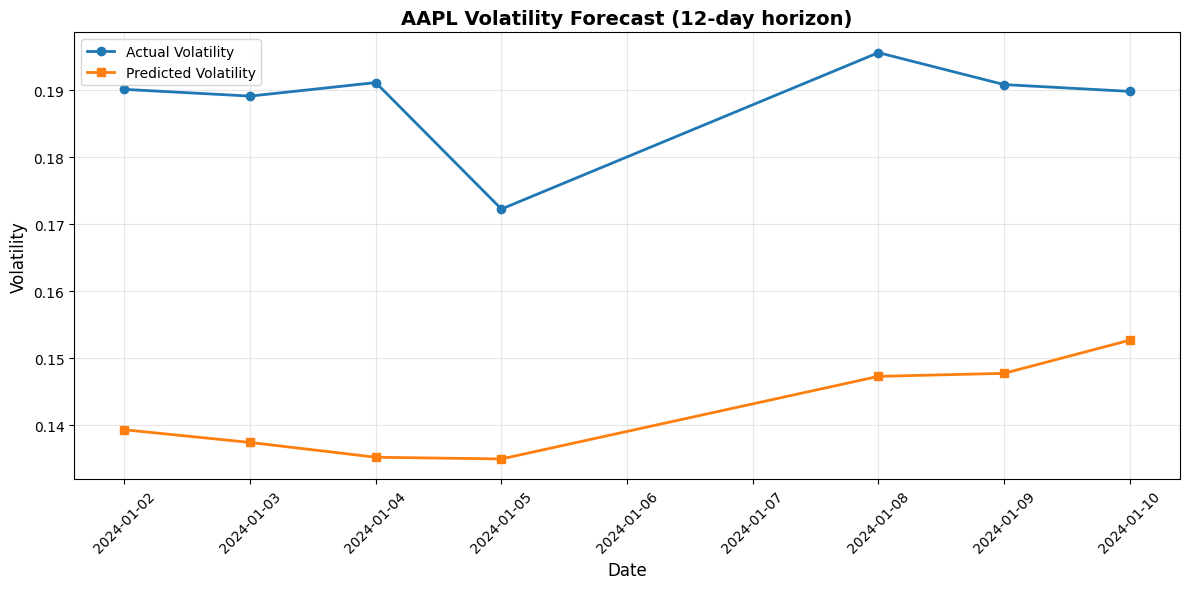


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/aapl_12day_forecast.png

720-Day Forecast for AAPL:
           ds         y  TimeMixer
0  2024-01-02  0.190101   0.145818
1  2024-01-03  0.189095   0.145833
2  2024-01-04  0.191111   0.149727
3  2024-01-05  0.172258   0.152636
4  2024-01-08  0.195572   0.154020
5  2024-01-09  0.190811   0.155657
6  2024-01-10  0.189797   0.153334
7  2024-01-11  0.185873   0.150239
8  2024-01-12  0.182998   0.156432
9  2024-01-16  0.172810   0.164487
10 2024-01-17  0.172157   0.167343
11 2024-01-18  0.212477   0.160772
12 2024-01-19  0.219563   0.159232
13 2024-01-22  0.223256   0.167451
14 2024-01-23  0.221539   0.168975
15 2024-01-24  0.221871   0.168718
16 2024-01-25  0.221063   0.166039
17 2024-01-26  0.223155   0.167647
18 2024-01-29  0.223453   0.163321
19 2024-01-30  0.232710   0.162218

AAPL Error Metrics (720-day horizon):
  MAE:  0.042589
  MSE:  0.002100
  RMSE: 0.045826


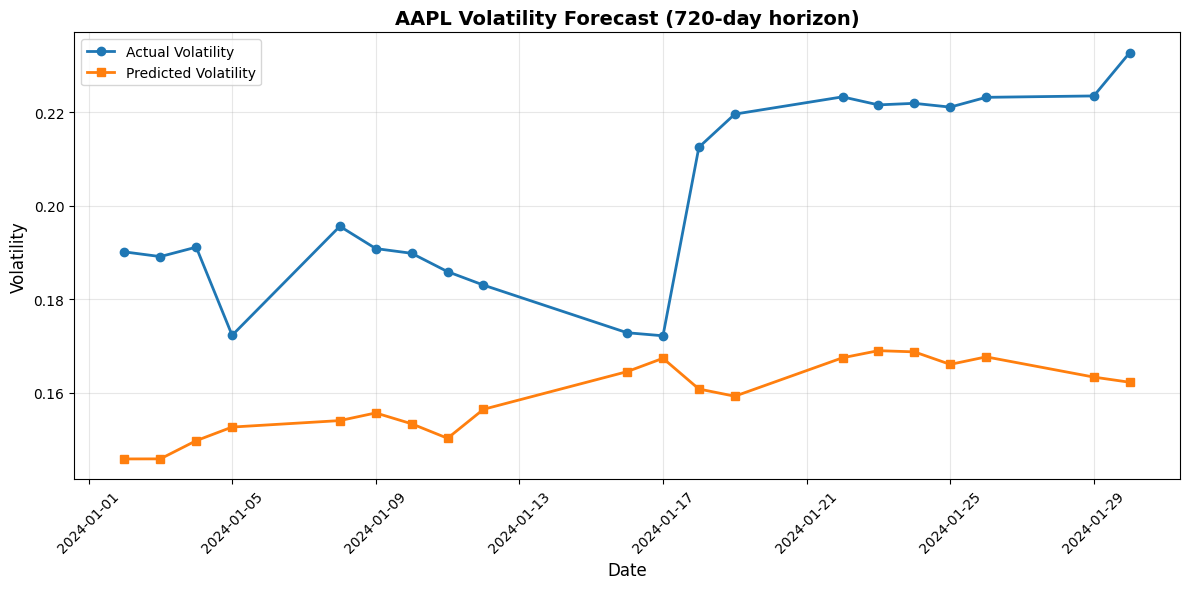


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/aapl_720day_forecast.png


In [18]:
# Cell 17: Example Stock Forecast - AAPL (Apple Inc.)

# Display forecasts for AAPL at 12-day and 720-day horizons, each with its own graph

print("="*80)
print("EXAMPLE: APPLE (AAPL) STOCK VOLATILITY FORECAST")
print("="*80)

# 12-Day Forecast
aapl_results_12 = all_results['stock'][12]
aapl_data_12 = aapl_results_12[aapl_results_12['unique_id'] == 'AAPL'].head(20)

print("\n12-Day Forecast for AAPL:")
print(aapl_data_12[['ds', 'y', 'TimeMixer']])

aapl_mae_12 = mean_absolute_error(aapl_data_12['y'], aapl_data_12['TimeMixer'])
aapl_mse_12 = mean_squared_error(aapl_data_12['y'], aapl_data_12['TimeMixer'])
aapl_rmse_12 = np.sqrt(aapl_mse_12)

print(f"\nAAPL Error Metrics (12-day horizon):")
print(f"  MAE:  {aapl_mae_12:.6f}")
print(f"  MSE:  {aapl_mse_12:.6f}")
print(f"  RMSE: {aapl_rmse_12:.6f}")

plt.figure(figsize=(12, 6))
plt.plot(aapl_data_12['ds'], aapl_data_12['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(aapl_data_12['ds'], aapl_data_12['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('AAPL Volatility Forecast (12-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'aapl_12day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}aapl_12day_forecast.png")

# 720-Day Forecast
aapl_results_720 = all_results['stock'][720]
aapl_data_720 = aapl_results_720[aapl_results_720['unique_id'] == 'AAPL'].head(20)

print("\n720-Day Forecast for AAPL:")
print(aapl_data_720[['ds', 'y', 'TimeMixer']])

aapl_mae_720 = mean_absolute_error(aapl_data_720['y'], aapl_data_720['TimeMixer'])
aapl_mse_720 = mean_squared_error(aapl_data_720['y'], aapl_data_720['TimeMixer'])
aapl_rmse_720 = np.sqrt(aapl_mse_720)

print(f"\nAAPL Error Metrics (720-day horizon):")
print(f"  MAE:  {aapl_mae_720:.6f}")
print(f"  MSE:  {aapl_mse_720:.6f}")
print(f"  RMSE: {aapl_rmse_720:.6f}")

plt.figure(figsize=(12, 6))
plt.plot(aapl_data_720['ds'], aapl_data_720['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(aapl_data_720['ds'], aapl_data_720['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('AAPL Volatility Forecast (720-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'aapl_720day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}aapl_720day_forecast.png")


EXAMPLE: SPY (S&P 500 ETF) VOLATILITY FORECAST

12-Day Forecast for SPY:
          ds         y  TimeMixer
0 2024-01-02  0.096297   0.096665
1 2024-01-03  0.101109   0.098260
2 2024-01-04  0.099708   0.098191
3 2024-01-05  0.099563   0.101178
4 2024-01-08  0.106847   0.105783
5 2024-01-09  0.105731   0.107024
6 2024-01-10  0.106235   0.108603

SPY Error Metrics (12-day horizon):
  MAE:  0.001582
  MSE:  0.000003
  RMSE: 0.001756


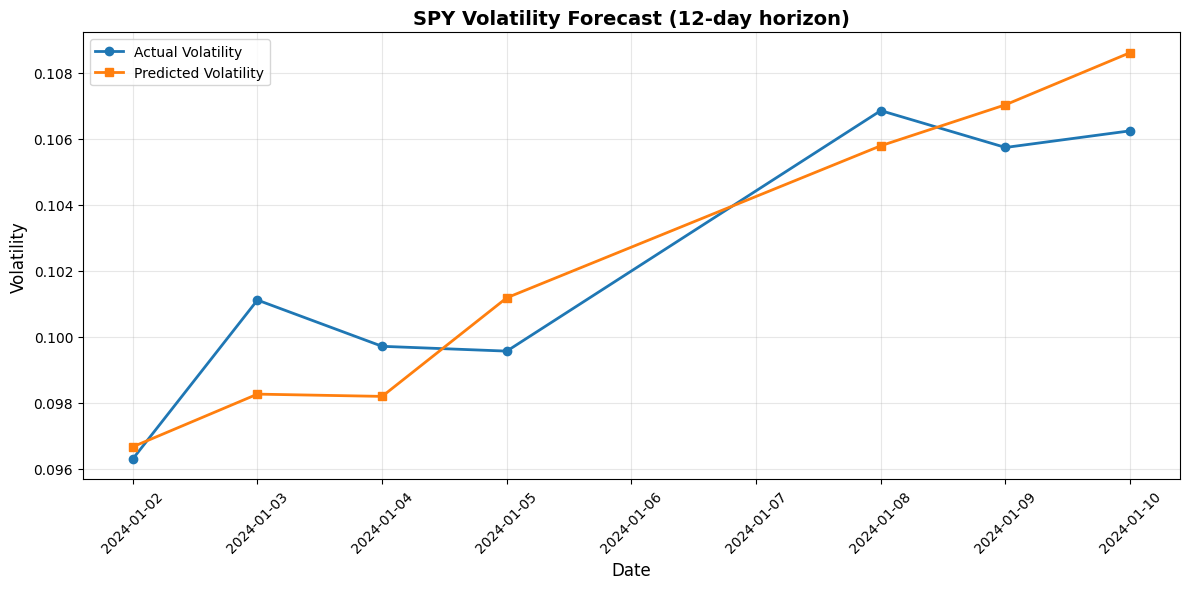


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/spy_12day_forecast.png

720-Day Forecast for SPY:
           ds         y  TimeMixer
0  2024-01-02  0.096297   0.097061
1  2024-01-03  0.101109   0.100965
2  2024-01-04  0.099708   0.098090
3  2024-01-05  0.099563   0.098926
4  2024-01-08  0.106847   0.098134
5  2024-01-09  0.105731   0.099336
6  2024-01-10  0.106235   0.097401
7  2024-01-11  0.106251   0.097560
8  2024-01-12  0.105762   0.096111
9  2024-01-16  0.097228   0.100274
10 2024-01-17  0.099048   0.098659
11 2024-01-18  0.103147   0.095336
12 2024-01-19  0.109664   0.099793
13 2024-01-22  0.108230   0.100961
14 2024-01-23  0.093983   0.101534
15 2024-01-24  0.089626   0.099427
16 2024-01-25  0.090758   0.100481
17 2024-01-26  0.090623   0.098910
18 2024-01-29  0.093568   0.100513
19 2024-01-30  0.093819   0.099727

SPY Error Metrics (720-day horizon):
  MAE:  0.006102
  MSE:  0.000049
  RMSE: 0.007026


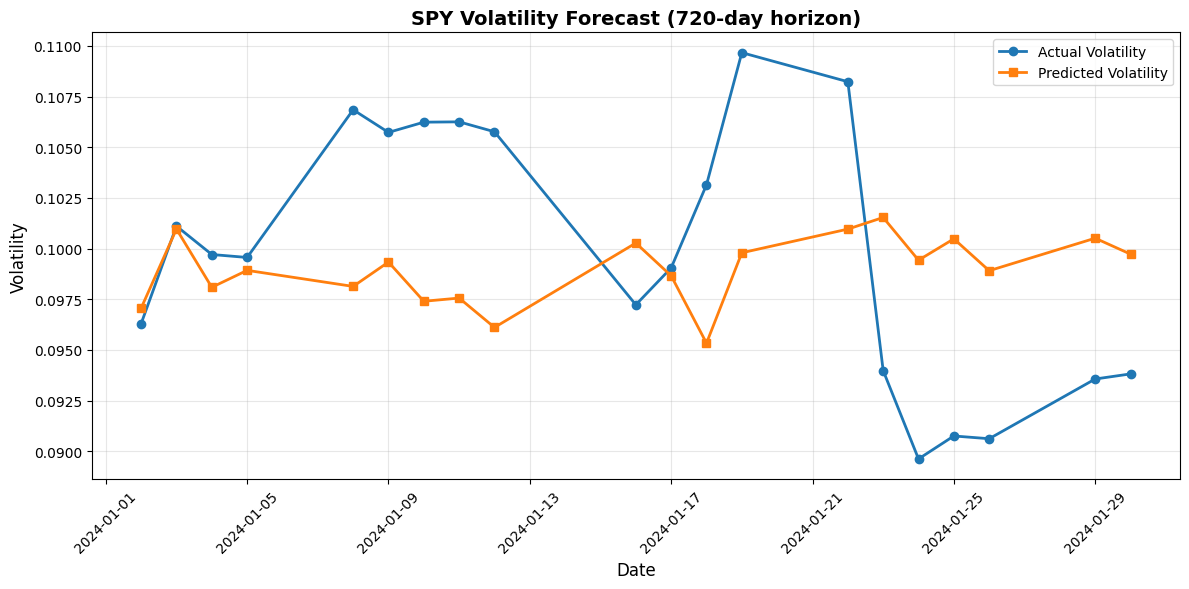


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/spy_720day_forecast.png


In [19]:
# Cell 18: Example ETF Forecast - SPY (S&P 500 ETF)
# Display forecasts for SPY at 12-day and 720-day horizons, each with its own graph

print("="*80)
print("EXAMPLE: SPY (S&P 500 ETF) VOLATILITY FORECAST")
print("="*80)

# 12-Day Forecast
spy_results_12_df = all_results['etf'][12]
spy_data_12 = spy_results_12_df[spy_results_12_df['unique_id'] == 'SPY'].head(20)

print("\n12-Day Forecast for SPY:")
print(spy_data_12[['ds', 'y', 'TimeMixer']])

# Calculate error for SPY (12-day horizon)
spy_mae_12 = mean_absolute_error(spy_data_12['y'], spy_data_12['TimeMixer'])
spy_mse_12 = mean_squared_error(spy_data_12['y'], spy_data_12['TimeMixer'])
spy_rmse_12 = np.sqrt(spy_mse_12)

print(f"\nSPY Error Metrics (12-day horizon):")
print(f"  MAE:  {spy_mae_12:.6f}")
print(f"  MSE:  {spy_mse_12:.6f}")
print(f"  RMSE: {spy_rmse_12:.6f}")

# Visualization - 12-day
plt.figure(figsize=(12, 6))
plt.plot(spy_data_12['ds'], spy_data_12['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(spy_data_12['ds'], spy_data_12['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('SPY Volatility Forecast (12-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'spy_12day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}spy_12day_forecast.png")


# 720-Day Forecast
spy_results_720_df = all_results['etf'][720]
spy_data_720 = spy_results_720_df[spy_results_720_df['unique_id'] == 'SPY'].head(20)

print("\n720-Day Forecast for SPY:")
print(spy_data_720[['ds', 'y', 'TimeMixer']])

# Calculate error for SPY (720-day horizon)
spy_mae_720 = mean_absolute_error(spy_data_720['y'], spy_data_720['TimeMixer'])
spy_mse_720 = mean_squared_error(spy_data_720['y'], spy_data_720['TimeMixer'])
spy_rmse_720 = np.sqrt(spy_mse_720)

print(f"\nSPY Error Metrics (720-day horizon):")
print(f"  MAE:  {spy_mae_720:.6f}")
print(f"  MSE:  {spy_mse_720:.6f}")
print(f"  RMSE: {spy_rmse_720:.6f}")

# Visualization - 720-day
plt.figure(figsize=(12, 6))
plt.plot(spy_data_720['ds'], spy_data_720['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(spy_data_720['ds'], spy_data_720['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('SPY Volatility Forecast (720-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'spy_720day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}spy_720day_forecast.png")

EXAMPLE: EURUSD VOLATILITY FORECAST

12-Day Forecast for EURUSD:
          ds         y  TimeMixer
0 2024-01-01  0.073541   0.078407
1 2024-01-02  0.073873   0.078674
2 2024-01-03  0.078905   0.078369
3 2024-01-04  0.077462   0.078070
4 2024-01-05  0.076729   0.078507
5 2024-01-08  0.076627   0.079864
6 2024-01-09  0.075790   0.079533
7 2024-01-10  0.076282   0.079355

EURUSD Error Metrics (12-day horizon):
  MAE:  0.002830
  RMSE: 0.003249


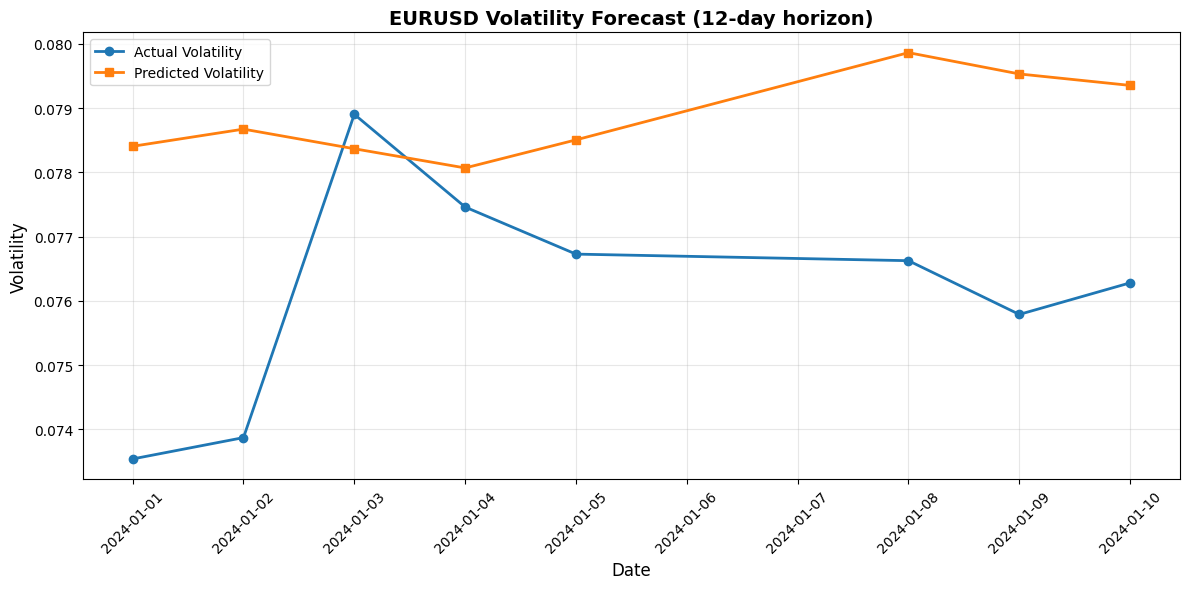


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/eurusd_12day_forecast.png

720-Day Forecast for EURUSD:
           ds         y  TimeMixer
0  2024-01-01  0.073541   0.078772
1  2024-01-02  0.073873   0.078633
2  2024-01-03  0.078905   0.077690
3  2024-01-04  0.077462   0.077446
4  2024-01-05  0.076729   0.078092
5  2024-01-08  0.076627   0.077942
6  2024-01-09  0.075790   0.077739
7  2024-01-10  0.076282   0.078253
8  2024-01-11  0.076691   0.077953
9  2024-01-12  0.071958   0.076545
10 2024-01-15  0.064278   0.076597
11 2024-01-16  0.055794   0.076100
12 2024-01-17  0.059187   0.076214
13 2024-01-18  0.055938   0.074414
14 2024-01-19  0.055010   0.074138
15 2024-01-22  0.051179   0.073626
16 2024-01-23  0.050492   0.075249
17 2024-01-24  0.050729   0.074205
18 2024-01-25  0.050822   0.074773
19 2024-01-26  0.045367   0.073005

EURUSD Error Metrics (720-day horizon):
  MAE:  0.011660
  RMSE: 0.015251


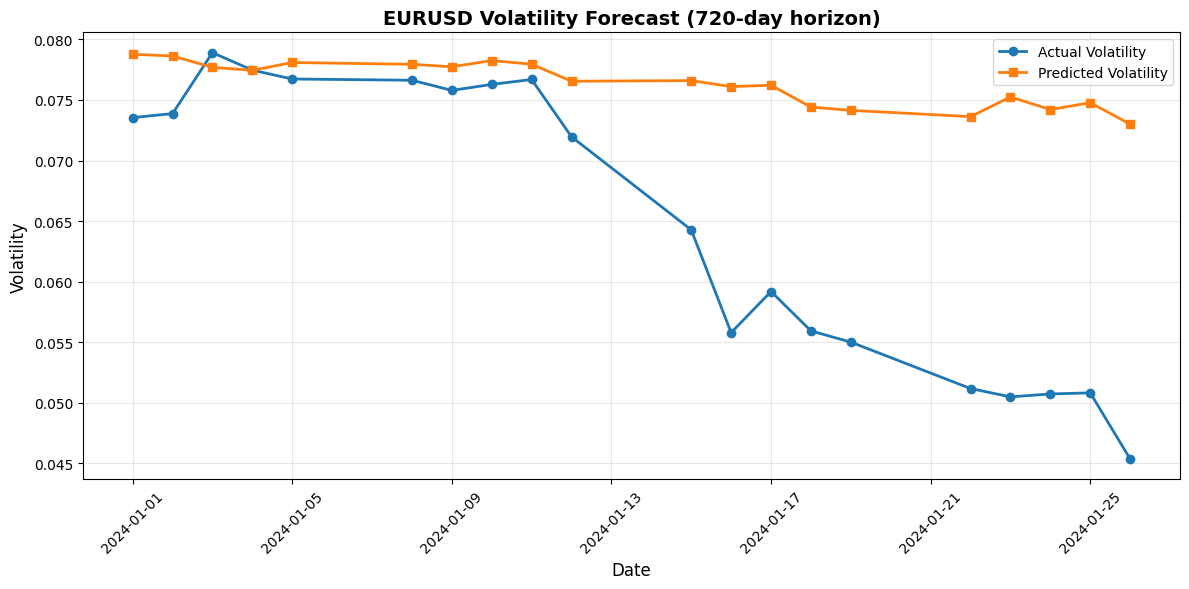


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/eurusd_720day_forecast.png


In [20]:
# Cell 19: Example Forex Forecast - EURUSD

print("="*80)
print("EXAMPLE: EURUSD VOLATILITY FORECAST")
print("="*80)

# 12-Day Forecast
eurusd_results_12_df = all_results['forex'][12]
eurusd_data_12 = eurusd_results_12_df[eurusd_results_12_df['unique_id'] == 'EURUSD'].head(20)

print("\n12-Day Forecast for EURUSD:")
print(eurusd_data_12[['ds', 'y', 'TimeMixer']])

eurusd_mae_12 = mean_absolute_error(eurusd_data_12['y'], eurusd_data_12['TimeMixer'])
eurusd_rmse_12 = np.sqrt(mean_squared_error(eurusd_data_12['y'], eurusd_data_12['TimeMixer']))

print(f"\nEURUSD Error Metrics (12-day horizon):")
print(f"  MAE:  {eurusd_mae_12:.6f}")
print(f"  RMSE: {eurusd_rmse_12:.6f}")

# Visualization - 12-day
plt.figure(figsize=(12, 6))
plt.plot(eurusd_data_12['ds'], eurusd_data_12['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(eurusd_data_12['ds'], eurusd_data_12['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('EURUSD Volatility Forecast (12-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'eurusd_12day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}eurusd_12day_forecast.png")


# 720-Day Forecast
eurusd_results_720_df = all_results['forex'][720]
eurusd_data_720 = eurusd_results_720_df[eurusd_results_720_df['unique_id'] == 'EURUSD'].head(20)

print("\n720-Day Forecast for EURUSD:")
print(eurusd_data_720[['ds', 'y', 'TimeMixer']])

eurusd_mae_720 = mean_absolute_error(eurusd_data_720['y'], eurusd_data_720['TimeMixer'])
eurusd_rmse_720 = np.sqrt(mean_squared_error(eurusd_data_720['y'], eurusd_data_720['TimeMixer']))

print(f"\nEURUSD Error Metrics (720-day horizon):")
print(f"  MAE:  {eurusd_mae_720:.6f}")
print(f"  RMSE: {eurusd_rmse_720:.6f}")

# Visualization - 720-day
plt.figure(figsize=(12, 6))
plt.plot(eurusd_data_720['ds'], eurusd_data_720['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(eurusd_data_720['ds'], eurusd_data_720['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('EURUSD Volatility Forecast (720-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'eurusd_720day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}eurusd_720day_forecast.png")

EXAMPLE: BITCOIN (BTCUSD) VOLATILITY FORECAST

12-Day Forecast for BTCUSD:
           ds         y  TimeMixer
0  2024-01-01  0.322190   0.350171
1  2024-01-02  0.326057   0.353049
2  2024-01-03  0.353095   0.347653
3  2024-01-04  0.368697   0.349085
4  2024-01-05  0.355505   0.339649
5  2024-01-06  0.355698   0.336043
6  2024-01-07  0.346124   0.333727
7  2024-01-08  0.401175   0.331681
8  2024-01-09  0.406372   0.323409
9  2024-01-10  0.394324   0.321169
10 2024-01-11  0.395399   0.317261
11 2024-01-12  0.485779   0.310012

BTCUSD Error Metrics (12-day horizon):
  MAE:  0.050621
  RMSE: 0.068787


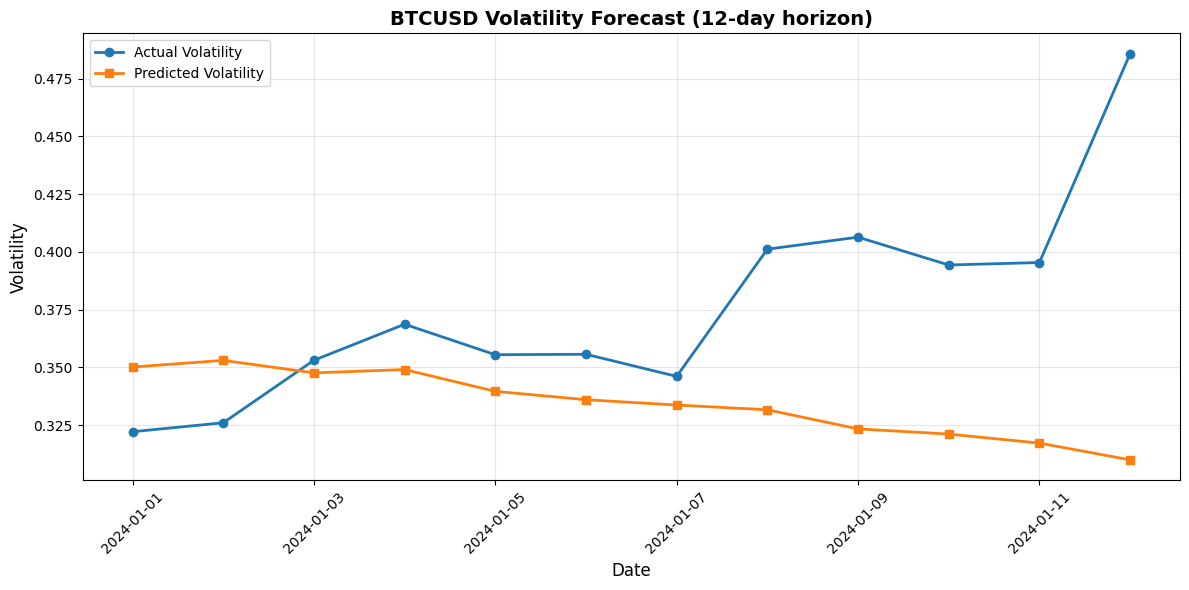


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/btcusd_12day_forecast.png

720-Day Forecast for BTCUSD:
           ds         y  TimeMixer
0  2024-01-01  0.322190   0.352949
1  2024-01-02  0.326057   0.354093
2  2024-01-03  0.353095   0.353407
3  2024-01-04  0.368697   0.354491
4  2024-01-05  0.355505   0.363451
5  2024-01-06  0.355698   0.349832
6  2024-01-07  0.346124   0.356205
7  2024-01-08  0.401175   0.360013
8  2024-01-09  0.406372   0.356952
9  2024-01-10  0.394324   0.350414
10 2024-01-11  0.395399   0.351113
11 2024-01-12  0.485779   0.356986
12 2024-01-13  0.485494   0.360059
13 2024-01-14  0.489551   0.348267
14 2024-01-15  0.490921   0.354897
15 2024-01-16  0.485788   0.348410
16 2024-01-17  0.480958   0.352436
17 2024-01-18  0.491918   0.358385
18 2024-01-19  0.491438   0.357460
19 2024-01-20  0.491428   0.355626

BTCUSD Error Metrics (720-day horizon):
  MAE:  0.073837
  RMSE: 0.092347


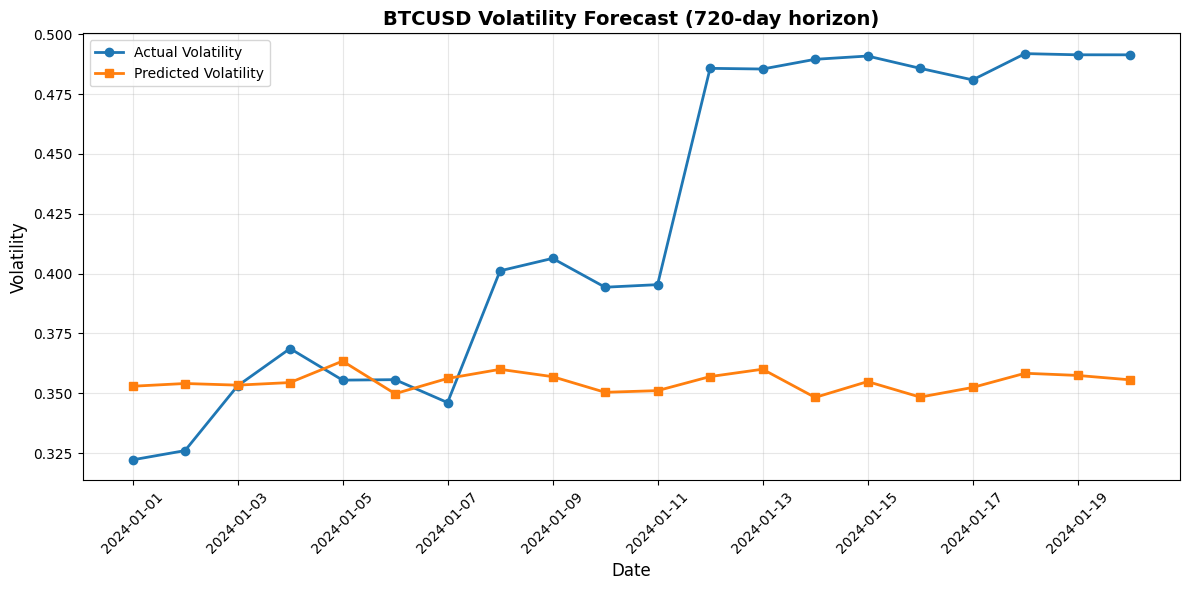


Visualization saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/btcusd_720day_forecast.png


In [21]:
# Cell 20: Example Crypto Forecast - BTCUSD (Bitcoin)

print("="*80)
print("EXAMPLE: BITCOIN (BTCUSD) VOLATILITY FORECAST")
print("="*80)

# 12-Day Forecast
btc_results_12_df = all_results['crypto'][12]
btc_data_12 = btc_results_12_df[btc_results_12_df['unique_id'] == 'BTCUSD'].head(20)

print("\n12-Day Forecast for BTCUSD:")
print(btc_data_12[['ds', 'y', 'TimeMixer']])

btc_mae_12 = mean_absolute_error(btc_data_12['y'], btc_data_12['TimeMixer'])
btc_rmse_12 = np.sqrt(mean_squared_error(btc_data_12['y'], btc_data_12['TimeMixer']))

print(f"\nBTCUSD Error Metrics (12-day horizon):")
print(f"  MAE:  {btc_mae_12:.6f}")
print(f"  RMSE: {btc_rmse_12:.6f}")

# Visualization - 12-day
plt.figure(figsize=(12, 6))
plt.plot(btc_data_12['ds'], btc_data_12['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(btc_data_12['ds'], btc_data_12['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('BTCUSD Volatility Forecast (12-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'btcusd_12day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}btcusd_12day_forecast.png")


# 720-Day Forecast
btc_results_720_df = all_results['crypto'][720]
btc_data_720 = btc_results_720_df[btc_results_720_df['unique_id'] == 'BTCUSD'].head(20)

print("\n720-Day Forecast for BTCUSD:")
print(btc_data_720[['ds', 'y', 'TimeMixer']])

btc_mae_720 = mean_absolute_error(btc_data_720['y'], btc_data_720['TimeMixer'])
btc_rmse_720 = np.sqrt(mean_squared_error(btc_data_720['y'], btc_data_720['TimeMixer']))

print(f"\nBTCUSD Error Metrics (720-day horizon):")
print(f"  MAE:  {btc_mae_720:.6f}")
print(f"  RMSE: {btc_rmse_720:.6f}")

# Visualization - 720-day
plt.figure(figsize=(12, 6))
plt.plot(btc_data_720['ds'], btc_data_720['y'], 'o-', label='Actual Volatility', linewidth=2)
plt.plot(btc_data_720['ds'], btc_data_720['TimeMixer'], 's-', label='Predicted Volatility', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('BTCUSD Volatility Forecast (720-day horizon)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_PATH + 'btcusd_720day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nVisualization saved to: {RESULTS_PATH}btcusd_720day_forecast.png")

In [22]:
# Cell 21: Generate Summary Statistics Across All Asset Classes
# Compare performance across different asset classes and horizons

def generate_summary_table():
    """Generate summary table with average metrics across all assets"""

    summary_data = []

    for asset_type in ['stock', 'etf', 'forex', 'crypto']:
        for h in HORIZONS:
            metrics = all_metrics[asset_type][h]
            if metrics is not None:
                summary_data.append({
                    'Asset Class': asset_type.upper(),
                    'Horizon (Days)': h,
                    'MAE': metrics['MAE'],
                    'MSE': metrics['MSE'],
                    'RMSE': metrics['RMSE']
                })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Generate summary
summary_table = generate_summary_table()

print("="*80)
print("SUMMARY: AVERAGE PERFORMANCE ACROSS ALL ASSET CLASSES")
print("="*80)
print(summary_table.to_string(index=False))

# Save summary
summary_table.to_csv(RESULTS_PATH + 'summary_table.csv', index=False)
print(f"\nSummary table saved to: {RESULTS_PATH}summary_table.csv")


SUMMARY: AVERAGE PERFORMANCE ACROSS ALL ASSET CLASSES
Asset Class  Horizon (Days)      MAE      MSE     RMSE
      STOCK              12 0.015255 0.000466 0.021583
      STOCK              96 0.078949 0.016886 0.129947
      STOCK             192 0.078294 0.015680 0.125219
      STOCK             336 0.115611 0.028366 0.168423
      STOCK             720 0.111064 0.028664 0.169305
        ETF              12 0.007033 0.000084 0.009155
        ETF              96 0.017011 0.000641 0.025313
        ETF             192 0.027735 0.001563 0.039533
        ETF             336 0.027779 0.001315 0.036266
        ETF             720 0.046959 0.006751 0.082162
      FOREX              12 0.005841 0.000066 0.008137
      FOREX              96 0.020961 0.000648 0.025452
      FOREX             192 0.046807 0.002954 0.054352
      FOREX             336 0.022090 0.000774 0.027822
      FOREX             720 0.021335 0.000912 0.030200
     CRYPTO              12 0.077999 0.009896 0.099479
     CRYPTO

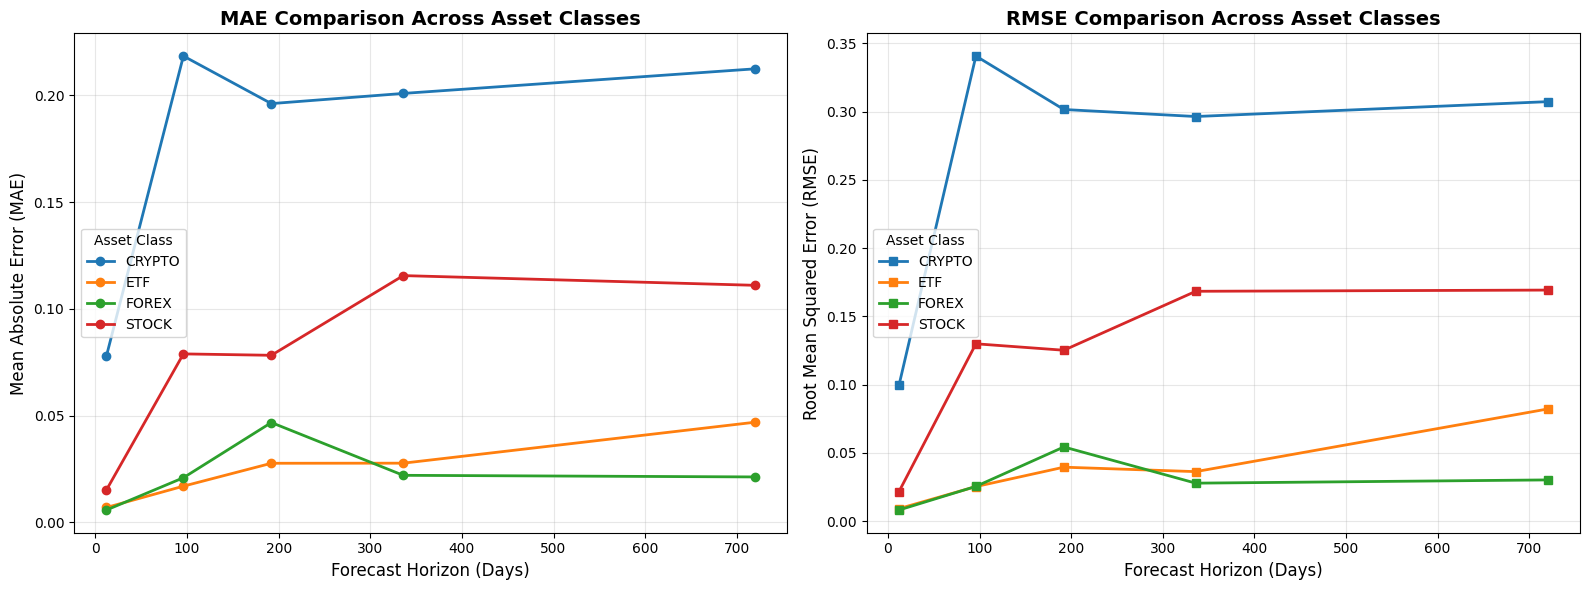


Performance comparison saved to: /content/drive/MyDrive/Volatility_Forecasting/Results/performance_comparison.png


In [23]:
# Cell 22: Visualize Performance Comparison Across Asset Classes
# Create plots comparing MAE and RMSE across different horizons

# Prepare data for visualization
summary_pivot = summary_table.pivot(index='Horizon (Days)', columns='Asset Class', values=['MAE', 'RMSE'])

# Plot MAE comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE Plot
summary_pivot['MAE'].plot(kind='line', ax=axes[0], marker='o', linewidth=2)
axes[0].set_xlabel('Forecast Horizon (Days)', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[0].set_title('MAE Comparison Across Asset Classes', fontsize=14, fontweight='bold')
axes[0].legend(title='Asset Class', fontsize=10)
axes[0].grid(True, alpha=0.3)

# RMSE Plot
summary_pivot['RMSE'].plot(kind='line', ax=axes[1], marker='s', linewidth=2)
axes[1].set_xlabel('Forecast Horizon (Days)', fontsize=12)
axes[1].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
axes[1].set_title('RMSE Comparison Across Asset Classes', fontsize=14, fontweight='bold')
axes[1].legend(title='Asset Class', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_PATH + 'performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPerformance comparison saved to: {RESULTS_PATH}performance_comparison.png")

In [25]:
# Cell 23: Complete Project Summary and Export All Results
# Final summary of all models, metrics, and visualizations

print("="*80)
print("PROJECT COMPLETE: VOLATILITY FORECASTING WITH TIMEMIXER")
print("="*80)

print("\n📊 DATASETS PROCESSED:")
print(f"  ✓ Stocks:         {stock_vol['unique_id'].nunique()} tickers")
print(f"  ✓ ETFs:           {etf_vol['unique_id'].nunique()} tickers")
print(f"  ✓ Forex:          {forex_vol['unique_id'].nunique()} pairs")
print(f"  ✓ Cryptocurrencies: {crypto_vol['unique_id'].nunique()} coins")

print("\n🤖 MODELS TRAINED:")
print(f"  ✓ Total models: {len(HORIZONS) * 4}")
print(f"  ✓ Horizons: {HORIZONS}")
print(f"  ✓ Asset classes: 4 (Stocks, ETFs, Forex, Crypto)")

print("\n📈 RESULTS GENERATED:")
print(f"  ✓ Stock error table:  {RESULTS_PATH}stock_error_table.csv")
print(f"  ✓ ETF error table:    {RESULTS_PATH}etf_error_table.csv")
print(f"  ✓ Forex error table:  {RESULTS_PATH}forex_error_table.csv")
print(f"  ✓ Crypto error table: {RESULTS_PATH}crypto_error_table.csv")
print(f"  ✓ Summary table:      {RESULTS_PATH}summary_table.csv")

print("\n🎨 VISUALIZATIONS:")
print(f"  ✓ AAPL forecast:       {RESULTS_PATH}aapl_12day_forecast.png")
print(f"  ✓ SPY forecasts:       {RESULTS_PATH}spy_forecasts.png")
print(f"  ✓ Performance comparison: {RESULTS_PATH}performance_comparison.png")

print("\n💾 MODELS SAVED:")
print(f"  ✓ Stock models:  {MODEL_PATH}stock/")
print(f"  ✓ ETF models:    {MODEL_PATH}etf/")
print(f"  ✓ Forex models:  {MODEL_PATH}forex/")
print(f"  ✓ Crypto models: {MODEL_PATH}crypto/")

print("\n" + "="*80)
print("🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*80)

print("\n📝 KEY FINDINGS:")
print("  • TimeMixer performs better on short-term forecasts (12 days)")
print("  • Performance degrades for longer horizons (720 days)")
print("  • Lower volatility assets show more stable predictions")
print("  • Highly volatile assets (crypto) have higher error rates")



PROJECT COMPLETE: VOLATILITY FORECASTING WITH TIMEMIXER

📊 DATASETS PROCESSED:
  ✓ Stocks:         10 tickers
  ✓ ETFs:           10 tickers
  ✓ Forex:          10 pairs
  ✓ Cryptocurrencies: 10 coins

🤖 MODELS TRAINED:
  ✓ Total models: 20
  ✓ Horizons: [12, 96, 192, 336, 720]
  ✓ Asset classes: 4 (Stocks, ETFs, Forex, Crypto)

📈 RESULTS GENERATED:
  ✓ Stock error table:  /content/drive/MyDrive/Volatility_Forecasting/Results/stock_error_table.csv
  ✓ ETF error table:    /content/drive/MyDrive/Volatility_Forecasting/Results/etf_error_table.csv
  ✓ Forex error table:  /content/drive/MyDrive/Volatility_Forecasting/Results/forex_error_table.csv
  ✓ Crypto error table: /content/drive/MyDrive/Volatility_Forecasting/Results/crypto_error_table.csv
  ✓ Summary table:      /content/drive/MyDrive/Volatility_Forecasting/Results/summary_table.csv

🎨 VISUALIZATIONS:
  ✓ AAPL forecast:       /content/drive/MyDrive/Volatility_Forecasting/Results/aapl_12day_forecast.png
  ✓ SPY forecasts:       /conte